# RNA-seq

In this project, I elaborate an analysis pipeline for RNA-seq data through the creation of appropriate functions called from a single ```main``` script . 

The aim is therefore not to use functions from the most famous NGS data analysis packages but to create custom ones in order to work at a low level on the primitives.

Each step of the pipeline will be represented by a different function.

### **Pipeline scheme:**
 - Data normalization
 - Selection of differentially expressed genes
 - Biological interpretation with functional annotation
 - Clustering Expression Profiles (k-means)


## DATA

The data reproduce an experimental design in which the dynamics of **beta cells** gene expression is monitored under two conditions:

- activation of insulin secretion ("**INS**" samples)
- inhibition of insulin secretion ("**CTRL**" samples)

The data are stored in the file ```matcount_1095199.RData```, matrix 10000x78:

**N** = 10000 genes monitored

**M** = 13 time instants

3 **biological replicates** for each temporal instant

where:

```rownames(matcount) = EntrezID``` of the monitored genes
(http://www.ncbi.nlm.nih.gov/gene)

```colnames(matcount) = CONDITION.TIME.REPLICATES```

CONDITION = {"CTRL","INS"}

TIME = {"T0","T1",...,"T12"}

REPLICATES = {"REPL1","REPL2","REPL3"}



### LOAD DATA

In [4]:
rm(list=ls())
load("matcount_1095199.RData")
load("Disp_1095199.RData") # dispersion parameter

### DATA NORMALIZATION

The function ```TMMnorm.R```, which perform a normalization with the trimmed mean method (TMM) recives as inputs: 

```matr``` matrix to be normalised

```index``` index of the reference sample chosen to standardise

```param``` trim parameter to use for the average

As output it provides the same matrix with the normalized data using scaling normalization with TMM.
Furthermore it returns MvA plots. Each plot has 2 adjacent boxes showing the MvA plots (in log2-scale) of the sample before and after normalization 


In [5]:
source('TMMnorm.R')
matr.norm <- TMMnorm(matcount, 1, 0.1)

![alt text](plots_TMMnorm.svg)

### SELECTION OF DIFFERENTIALLY EXPRESSED GENES

In [6]:
# Eliminate genes that always have a count number <=1 
# on all 78 normalized samples

ind.rm <- c()
k <- 1
for (i in (1:nrow(matr.norm)))
{
  j <- 1
  while (j<=78)
  {
    if(matr.norm[i, j]<=1)
    {
      j <- j+1
      if(j==79)
      { ind.rm[k] <- i
      k <- k+1}
    }
    else j=79
      
  }
}

matr.filt <- matr.norm[-ind.rm,]

# create a 3-column data frame associating the column
# names of the normalized matrix to the times
# and conditions to be tested

samples <- colnames(matr.filt)
ind.C <- charToRaw("C")
condition <- c()
time_istant <- c()

for (i in (1:length(samples)))
{
  tmp <- charToRaw(samples[i])
  if (tmp[1]==ind.C)
    {
    condition[i] <- "CTRL"
    if (length(tmp)==13) 
        {time_istant[i] <- as.integer(rawToChar(tmp[7]))}
    else {time_istant[i] <- as.integer(rawToChar(tmp[7:8]))}
    }
  else
  {
    condition[i] <- "INS"
    if (length(tmp)==12)
    {time_istant[i] <- as.integer(rawToChar(tmp[6]))}
    else {time_istant[i] <- as.integer(rawToChar(tmp[6:7]))}
  }
  
}
time_istant <- time_istant-1

d.frame <- data.frame(Sample=samples, Time=time_istant, Condition=condition)


The selection of differentially expressed genes, after having prepared the data as shown above, takes place through two functions: ```TSdiff.R``` which in it calls ```NBdiff.test```.

```NBdiff.test```  for a fixed time period t_j (j=1,...,12) receives in input:

```X``` matrix of counts with the samples of the "CTRL" condition at time t_j

```Y``` matrix of counts with the samples of the "INS" condition at time t_j
 
```phi``` dispersion parameter

```type.test``` the selection method (string): "t_test", "Wald"

It returns a vector with the p-values associated with ```EntrezID``` of the genes, ordered by ```rownames(X)=rownames(Y)```.

Function ```Tsdiff.R``` calls the ```NBdiff.test``` function, applying it to each time instant by comparing ```CTRL``` vs. ```INS```. It takes as input:

```matr``` normalized and filtered counts matrix

```dataframe``` dataframe with information on the names of the samples

```phi``` a vector receiving the time-specific dispersion parameters

```pFP``` the highest tolerated pFP probability of committing a Type I error

```test``` the selection method (string): "t_test", "Wald"

```correction``` the correction method (string): 'NO_correction', 'Bonferroni', 'FDR'

```P0``` the percentage P0 of genes not differentially expressed


It returns a list of 2 items: 
- Element 1: a vector with EntrezIDs of genes differentially expressed in at least one temporal instant, 
- Element 2: a 12x4 matrix that shows, for each line, the TP, FP, TN and FN expected at time t_j (j=1,...,12) in correspondence to the threshold of required significance.


In [7]:
# load and execute the function to select the genes differentially expressed
# over time using the parameters that allow you to obtain the best solution

source('TSdiff.R')
list_TSdiff <- TSdiff(matr.filt, d.frame, disp, 0.05/12, 'Wald', 'Bonferroni', 0.99) 
#### if input != t_test or Wald, list_TSdiff[[1]] is empty; if selected = zero (t_test+Bonferroni)
#### quit or kmeans enters in loop

if(length(list_TSdiff[[1]])<=1){
  print(paste0("Insufficient number of selected genes"))
}


### BIOLOGICAL INTERPRETATION WITH FUNCTIONAL ANNOTATION

```GOannotations.txt``` and ```geneinfo.txt``` are delimited tab text files that contain the following information for each line:

```GOannotations.txt``` file:

```GOID```: GO term identifier

```Term```: Name of the GO term 

```Annotated_Genes```: genes annoted on that term (separator = ";")

File ```geneinfo.txt```:

```EntrezID```: Entrez ID of the gene, corresponding to the IDs on the data.

```GeneName```: name of the gene

```GeneSymbol```: symbol associated with the name of the gene





In [8]:
# load files "GOannotations.txt" and "geneinfo.txt"
GOannotations <- read.delim('GOannotations.txt', header=TRUE, sep="\t")
geneinfo <- read.delim('geneinfo.txt', header=TRUE ,sep="\t")

# create a data frame of 2 columns associating the name of the genes 
# to a flag indicating if the gene is (=1) or not (=0) selected
row.entrez <- rownames(matr.filt)
row.flag <- row.entrez%in%list_TSdiff[[1]]
row.flag[which(row.flag==TRUE)] <- 1
row.flag[which(row.flag==FALSE)] <- 0
flag.frame <- data.frame(EntrezID=row.entrez, Selcted=row.flag)


The ```EnrichGO.R``` function performs **enrichment analysis using Fisher's test**, considering an FDR correction for multiple tests, on all GO terms listed in the ```GOannotations.txt``` file.

It requires as input:

```flag.frame``` the data frame on the names of the selected/unselected genes

```GOannotations``` the data frame from ```GOannotations.txt```

```geneinfo``` the data frame from ```geneinfo.txt```


It returns in output a data frame, ordered according to increasing p-values, which reports for each row:

```GOID```: GO term identifier

```Term```: Name of the GO term

```p-value```: nominal p-value of the Fisher test.

```FDR```: The corresponding FDR, using P0=1

```Annotated```: number of genes annotated in the GO term

```Selected```: Number of selected genes that are annotated in the GO term

```EntrezID```: EntrezID identifiers of the genes selected in the GO term (separator = ";")

```Gene Name```: Names of genes selected in the GO term (separator = ";")

```Gene Symbol```: symbols of the genes selected in the GO term(separator = ';')

In [9]:
# load and execute the function for enrichment analysis
source('EnrichGO.R')
Enrich.frame <- EnrichGO(flag.frame, GOannotations, geneinfo)

In [14]:
# example of the first row of EnrichGO
head(Enrich.frame, 1)

,GOID,Term,p_value,FDR,Annotated,Selected,EntrezID,Gene_Name,Gene_Symbol
8206,GO:0051049,regulation of transport,7.767815e-40,1.722153e-37,644,54,88;287;358;776;777;845;1268;1813;2273;2281;2683;2740;2752;2887;3060;3091;3123;3356;3667;3741;3753;3757;3781;3784;3790;5649;5781;6262;6336;6375;6513;6514;6804;6934;7784;8398;8941;9254;10369;10411;10523;11060;11069;11315;22871;23236;26251;27113;50944;55503;57555;57829;85358;415116,"calcium channel, voltage-dependent, gamma subunit 2;Rap guanine nucleotide exchange factor (GEF) 3;calcium homeostasis endoplasmic reticulum protein;WW domain containing E3 ubiquitin protein ligase 2;Rap guanine nucleotide exchange factor (GEF) 4;parkinson protein 7;cannabinoid receptor 1 (brain);dopamine receptor D2;four and a half LIM domains 1;FK506 binding protein 1B, 12.6 kDa;neuroligin 1;phospholipase C, beta 1 (phosphoinositide-specific);potassium voltage-gated channel, subfamily G, member 2;UDP-Gal:betaGlcNAc beta 1,4- galactosyltransferase, polypeptide 1;BCL2 binding component 3;glucagon-like peptide 1 receptor;glutamate-ammonia ligase;ankyrin 2, neuronal;growth factor receptor-bound protein 10;hypocretin (orexin) neuropeptide precursor;hypoxia inducible factor 1, alpha subunit (basic helix-loop-helix transcription factor);major histocompatibility complex, class II, DR beta 1;5-hydroxytryptamine (serotonin) receptor 2A, G protein-coupled;aquaporin 1 (Colton blood group);insulin receptor substrate 1;potassium voltage-gated channel, shaker-related subfamily, member 5;potassium voltage-gated channel, Isk-related family, member 1;potassium voltage-gated channel, subfamily H (eag-related), member 2;potassium intermediate/small conductance calcium-activated channel, subfamily N, member 2;potassium voltage-gated channel, KQT-like subfamily, member 1;potassium voltage-gated channel, delayed-rectifier, subfamily S, member 3;pim-3 oncogene;SH3 and multiple ankyrin repeat domains 1;transient receptor potential cation channel, subfamily V, member 6;reelin;neuroligin 2;protein tyrosine phosphatase, non-receptor type 11;zona pellucida glycoprotein 4;ryanodine receptor 2 (cardiac);sodium channel, voltage-gated, type X, alpha subunit;chemokine (C motif) ligand 1;solute carrier family 2 (facilitated glucose transporter), member 1;solute carrier family 2 (facilitated glucose transporter), member 2;syntaxin 1A (brain);transcription factor 7-like 2 (T-cell specific, HMG-box);calcium channel, voltage-dependent, L type, alpha 1D subunit;calcium channel, voltage-dependent, R type, alpha 1E subunit;zona pellucida glycoprotein 3 (sperm receptor);phospholipase A2, group VI (cytosolic, calcium-independent);calsequestrin 2 (cardiac muscle);SH3 and multiple ankyrin repeat domains 3;actinin, alpha 2;cyclin-dependent kinase 5, regulatory subunit 2 (p39);calcium channel, voltage-dependent, alpha 2/delta subunit 2",CACNG2;RAPGEF3;CHERP;WWP2;RAPGEF4;PARK7;CNR1;DRD2;FHL1;FKBP1B;NLGN1;PLCB1;KCNG2;B4GALT1;BBC3;GLP1R;GLUL;ANK2;GRB10;HCRT;HIF1A;HLA-DRB1;HTR2A;AQP1;IRS1;KCNA5;KCNE1;KCNH2;KCNN2;KCNQ1;KCNS3;PIM3;SHANK1;TRPV6;RELN;NLGN2;PTPN11;ZP4;RYR2;SCN10A;XCL1;SLC2A1;SLC2A2;STX1A;TCF7L2;CACNA1D;CACNA1E;ZP3;PLA2G6;CASQ2;SHANK3;ACTN2;CDK5R2;CACNA2D2


### CLUSTERING EXPRESSION PROFILES (K-MEANS)

First some pre-processing is required:

In [15]:
# extract differentially expressed genes from normalised data,
# average replicates, log-transform (with offsets) and calculate treatment-control
ind.diff <- which(flag.frame$Selcted==1)
matr.diff <- matr.filt[ind.diff,]

MAT <- matrix(0,length(ind.diff),13)
rownames(MAT) <- rownames(matr.diff)
for (i in (1:13)){ # using d.frame, I already have the disjointed names of the variables 
  ind.CTRL <- which(d.frame$Time==(i-1) & d.frame$Condition=='CTRL')
  ind.INS <- which(d.frame$Time==(i-1) & d.frame$Condition=='INS')
  # calculate average of replicates
  if(is.null(nrow(matr.diff))){
    mean_CTRL <- mean(matr.diff[ind.CTRL])
    mean_INS <- mean(matr.diff[ind.INS])
    } else{
  mean_CTRL <- apply(matr.diff[,ind.CTRL],1,mean)
  mean_INS <- apply(matr.diff[,ind.INS],1,mean)
  MAT[,i] <- log(mean_INS+1)-log(mean_CTRL+1)}
}


The function ```K_means.R``` returns in output a list containing the genes grouped in K cluster and the K centroids.
It gives the possibility to choose the type of distance to use ```Euclidean``` or ```Correlation```, by calling the function ```measure.R```.

```K_means.R``` receives as input:   

```MAT``` data matrix

```K``` number of clusters

```measure_type``` choice between "```Correlation```" or "```Euclidean```" distance in clustering

```R``` number of restarts of the k-means algorithm

```SEED``` Random number generator SEED

```list``` containing the genes grouped in K clusters and K centroids


As an EXTERNAL termination condition we impose that Restarts are reached, as an INTERNAL condition that none of the genes changes cluster in the entire FOR cycle


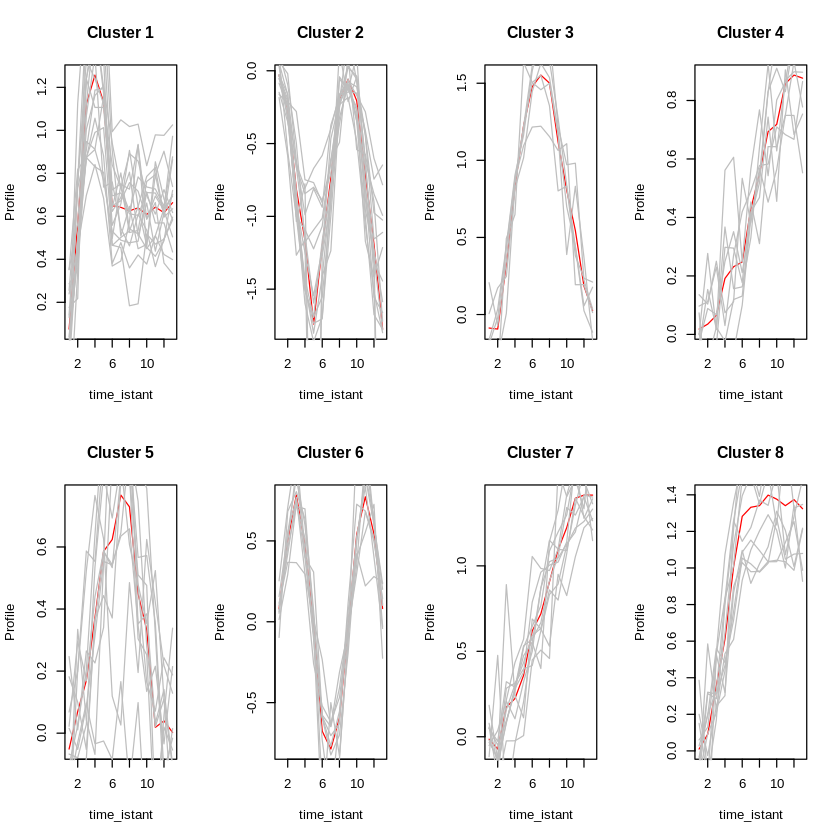

In [16]:
# load and run the k-means clustering function, 
# selecting an adequate number of clusters and algorithm
# restarts and an adequate distance measurement
source('K_means.R')
K <- 8
R <- 300
SEED <- 11

### 2 methods: "Euclidean", "Correlation"
list_Kmeans <- K_means(MAT, K, 'Euclidean', R, SEED)

# plot all the clusters in a single figure, arranged in two lines,
# with the time profiles of the individual elements in grey and the centroid in red

# create layout, plots in 2 rows
if(K%%2==0) {num.colonne=K/2} else
{num.colonne=(K%/%2+1)}
  
layout(matrix(c(1:(2*num.colonne)),2,num.colonne,byrow=TRUE))
for (i in (1:K)) {
  plot(list_Kmeans$centroids[i,],type="l",col="red",main=paste("Cluster",i),xlab="time_istant",ylab="Profile")
  num.el <- length(which(list_Kmeans$clustering==i))
  if (num.el!=0) {
    elementi <- which(list_Kmeans$clustering==i)
    for (j in (1:num.el)) 
      lines(MAT[elementi[j],],col="grey")
  }
}